# Exploration du jeu de données nettoyé

### Settings et import des données

In [1]:
%matplotlib inline
import pandas as pd
import csv as csv
import numpy as np 
import matplotlib.pyplot as plt
import os as os
import seaborn as sns 
import scipy.stats as st
import bokeh as bk
from random import sample
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import Imputer
from scipy import stats
from sklearn.decomposition import PCA
from sklearn import linear_model
from scipy.stats.stats import pearsonr


os.getcwd()
os.chdir("C:/Users/flemeill/Documents/01 - Projets OC/02 - Projet 2/Main project")

Paramètrage des graphiques 

In [2]:
plt.style.use('seaborn-deep')
sns.set_style('dark')
sns.set(rc={'figure.figsize':(9,6)})
sns.set(rc={'font.size':21})

Import du jeu de données

In [3]:
Data = pd.read_csv('new_data_openfood.csv')
print(Data.shape)

# Les index du dataframe précédent se sont ajoutés dans la première colonne. 
# Comme ils ne nous sont plus utiles nous les supprimons ici
Data = Data.drop('Unnamed: 0',axis=1)
print(Data.columns)
print(Data.shape)

(82002, 24)
Index(['categories_fr', 'brands_tags', 'main_category_fr', 'product_name',
       'countries_fr', 'nutrition_grade_fr', 'additives_n',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'SommeGPL', 'Score_Moyen', 'kCal_100g'],
      dtype='object')
(82002, 23)


On enlève également la variable 'energy_100g' qui fait doublon avec la variable 'kCal_100g'

In [4]:
Data = Data.drop(['energy_100g'], axis=1)
print(Data.shape)

(82002, 22)


On choisit aussi de ne considérer plus que la variable Score_Moyen pour mesurer le score nutritionnel     
Ce choix se justifie par le fait que Score_Moyen représente la moyenne des deux score Uk et Fr et est détaillé en fin de notebook 

In [5]:
Data = Data.drop(['nutrition-score-fr_100g','nutrition-score-uk_100g'], axis = 1)

Création du sous jeu de données contenant uniquement des valeurs numériques 

In [6]:
Data_float = Data.select_dtypes(include=['float64'])
print(Data_float.shape)
Data_text = Data.select_dtypes(include=['object'])
print(Data_text.shape)
print(Data_text.columns)

(82002, 14)
(82002, 6)
Index(['categories_fr', 'brands_tags', 'main_category_fr', 'product_name',
       'countries_fr', 'nutrition_grade_fr'],
      dtype='object')


# Réalisation d'études univariées sur les variables clés du problèmes

Dans un premier temps nous étudions les propriétés intrasèques des variables suivantes :     
    - 'fat_100g'  
    - 'Score_Moyen'   
    - 'carbohydrates_100g'   
    - 'saturated_fat_100g'   
    - 'proteins_100g'   
    - 'kCal_100g'

Fonctions permettant d'afficher les différents graphiques régulièrement utilisés dans la suite 

In [7]:
def DistriPlot(Var,X):
    sns.distplot(Var)
    plt.xlabel(X, fontsize = 18)
    plt.ylabel("Distribution", fontsize = 18)
    plt.title("Distribution de " + X, fontsize = 24)
    print("La médiane de ",X, "est de ",Var.median())
    print("La moyenne de ",X, "est de ",Var.mean() )
    #plt.show

def BoxPlot2D(X,Y): 
    sns.boxplot(X,Y)
    plt.xlabel(X)
    plt.ylabel(Y)
    plt.title('Boxplot', fontsize =24)
    
def BoxPlot1D(X , title):
    sns.boxplot(X)
    plt.title(title,fontsize =24)
    print(X.describe())
        
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]]) 

On tronque ici les variables devant être entières.    
Le choix de la troncature se fait car les variables non entières sont issues du remplissage par interpolation.    
Or une valeur "NaN" me semble avoir plus de chances d'être inférieur à celle prédite par interpolation

In [8]:
Data["additives_n"] = Data["additives_n"].apply(lambda x: float(truncate(x,0)))
Data["ingredients_from_palm_oil_n"] = Data["ingredients_from_palm_oil_n"].apply(lambda x: float(truncate(x,0)))
Data["ingredients_that_may_be_from_palm_oil_n"] = Data["ingredients_that_may_be_from_palm_oil_n"].apply(lambda x: float(truncate(x,0)))

On visualise une première fois de manière rapide les histogrammes de l'ensemble des variables numériques

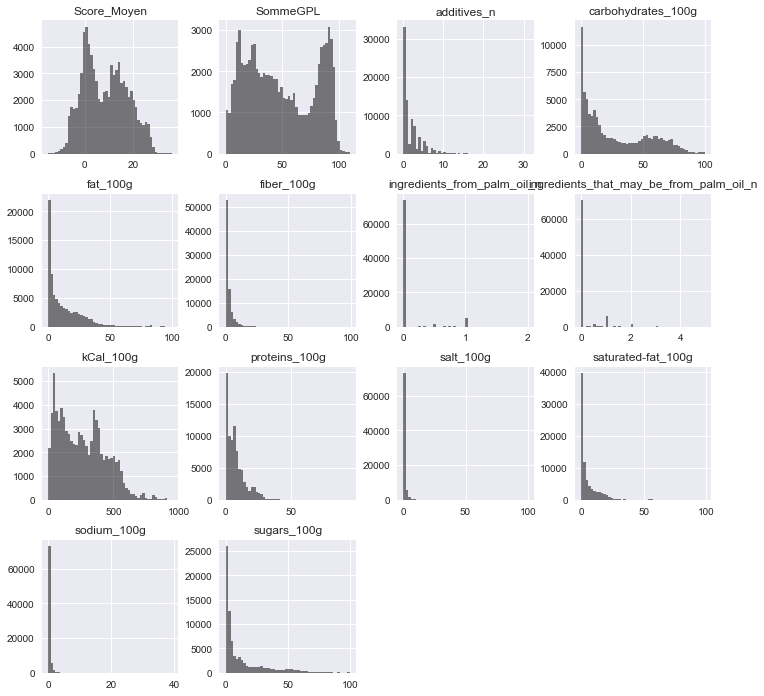

In [9]:
Data_float.hist(color='k', alpha=0.5, bins=50, figsize=(12,12))
plt.show()

#### Etude de la variable 'fat_100g'

La médiane de  teneur en lipides (graisses) pour 100g est de  7.661428571428572
La moyenne de  teneur en lipides (graisses) pour 100g est de  13.029704619293332


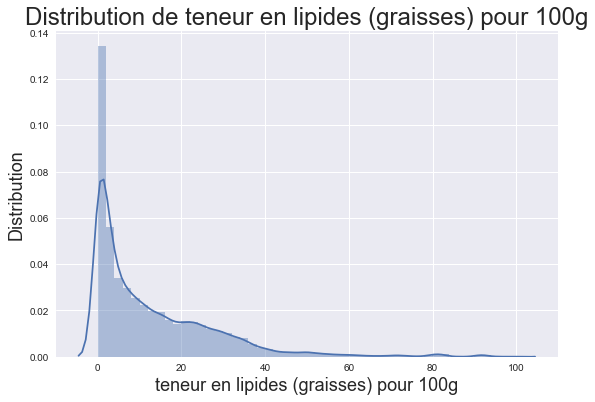

In [10]:
DistriPlot(Data.fat_100g,'teneur en lipides (graisses) pour 100g')

count    82002.000000
mean        13.029705
std         15.148018
min          0.000000
25%          1.600000
50%          7.661429
75%         20.300000
max         99.900000
Name: fat_100g, dtype: float64


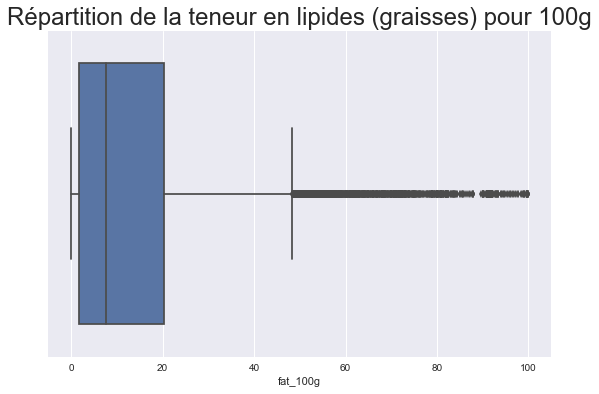

In [11]:
BoxPlot1D(Data['fat_100g'], 'Répartition de la teneur en lipides (graisses) pour 100g')

Zone de commentaires :    
La distribution est unimodale, de mode 0, et la boite à moustache nous indique que 
75% des produits contiennent moins de 20g de lipides pour 100g    
On observe tout de même la présence de nombreux outliers très riches en lipides
ce qui peut expliquer la différence importante entre la médiane et la moyenne

#### Etude de la variable 'Score_Moyen'

La médiane de  Score nutritionnel est de  8.0
La moyenne de  Score nutritionnel est de  8.573089883132589


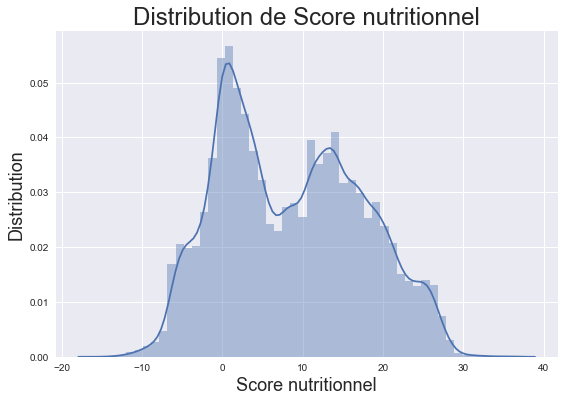

In [12]:
DistriPlot(Data.Score_Moyen,'Score nutritionnel')

count    82002.000000
mean         8.573090
std          8.823664
min        -15.000000
25%          1.000000
50%          8.000000
75%         15.500000
max         36.000000
Name: Score_Moyen, dtype: float64


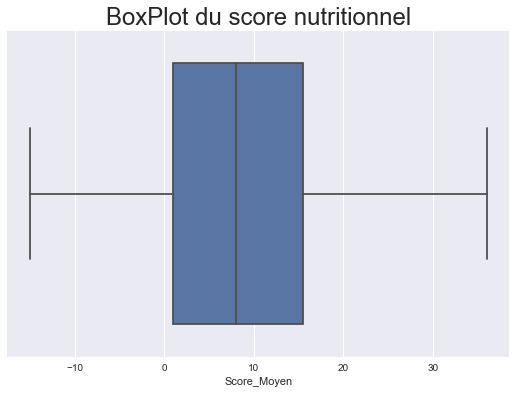

In [13]:
BoxPlot1D(Data['Score_Moyen'], 'BoxPlot du score nutritionnel')

Zone de commentaires :   
La distribution est bimodale, de modes 0 et 15. La boite à moustache nous indique d'ailleurs que 
plus de 50% des scores des produits sont situés entre ces deux valeurs.   
Enfin la médiane et la moyenne sont très proches

#### Etude de la variable 'carbohydrates_100g'

La médiane de  Teneur en glucides pour 100g est de  17.3
La moyenne de  Teneur en glucides pour 100g est de  28.073680377882425


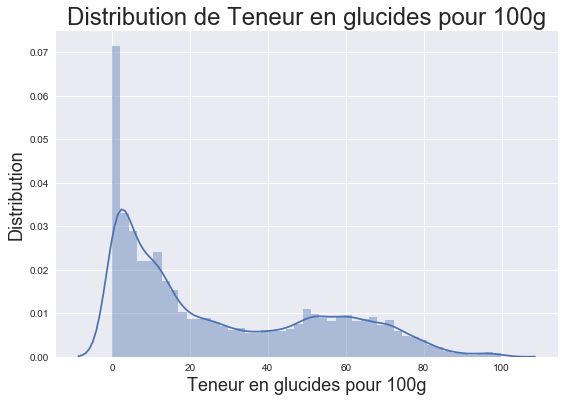

In [14]:
DistriPlot(Data.carbohydrates_100g,'Teneur en glucides pour 100g')

count    82002.000000
mean        28.073680
std         26.073468
min          0.000000
25%          5.000000
50%         17.300000
75%         51.223750
max         99.940000
Name: carbohydrates_100g, dtype: float64


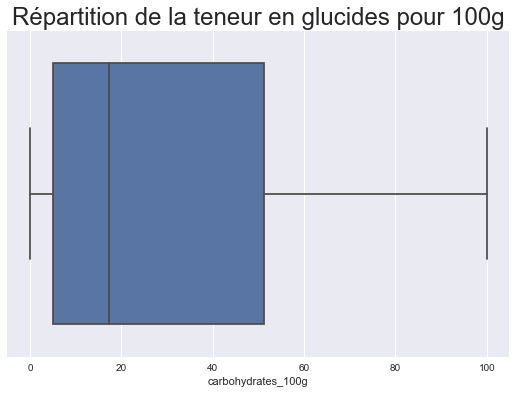

In [15]:
BoxPlot1D(Data['carbohydrates_100g'], 'Répartition de la teneur en glucides pour 100g')

Zone de commentaires     
La distribution de la teneur en glucide est unimodale, de mode 0. Cependant la boite à moustache et le graphe de distribution
nous indiquent que la distribution est assez bien repartie entre 0 et 100

#### Etude de la variable 'saturated_fat_100g'

La médiane de  Teneur en gras saturés pour 100g est de  2.0
La moyenne de  Teneur en gras saturés pour 100g est de  5.40779784644016


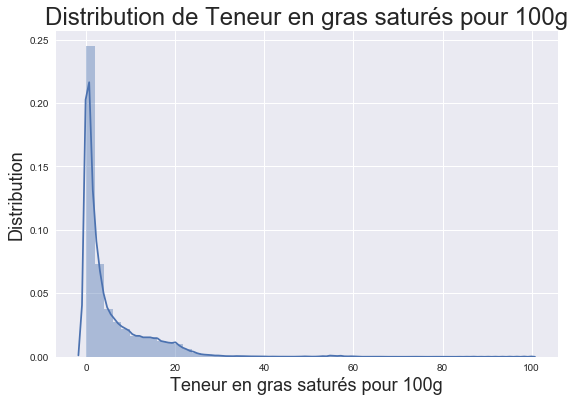

In [16]:
DistriPlot(Data['saturated-fat_100g'],'Teneur en gras saturés pour 100g')

count    82002.000000
mean         5.407798
std          8.103942
min          0.000000
25%          0.400000
50%          2.000000
75%          7.500000
max         99.000000
Name: saturated-fat_100g, dtype: float64


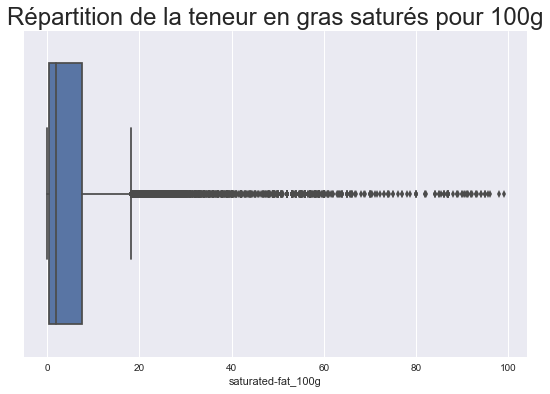

In [17]:
BoxPlot1D(Data['saturated-fat_100g'], 'Répartition de la teneur en gras saturés pour 100g')

Zone de commentaires :    
La distribution des graisses saturées est unimodale, de mode 0 qui est aussi le minimum. 
La grande majorité des valeurs se situe d'ailleurs proche de ce minimum : La médiane est de 2.   
On constate, comme pour les lipides, la présence de nombreux outliers avec des valeurs élevées en graisses saturées
Ce sont souvent des produits spécifiques comme les huiles de cuisines.


#### Etude de la variable 'proteins_100g'

La médiane de  Teneur en protéines pour 100g est de  6.0
La moyenne de  Teneur en protéines pour 100g est de  7.695949591705537


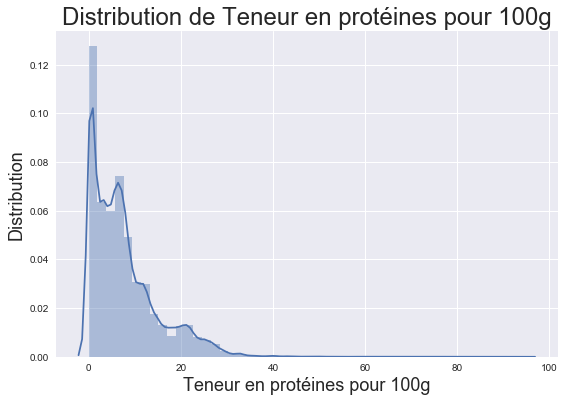

In [18]:
DistriPlot(Data['proteins_100g'],'Teneur en protéines pour 100g')

count    82002.000000
mean         7.695950
std          7.485289
min          0.000000
25%          2.000000
50%          6.000000
75%         11.000000
max         94.700000
Name: proteins_100g, dtype: float64


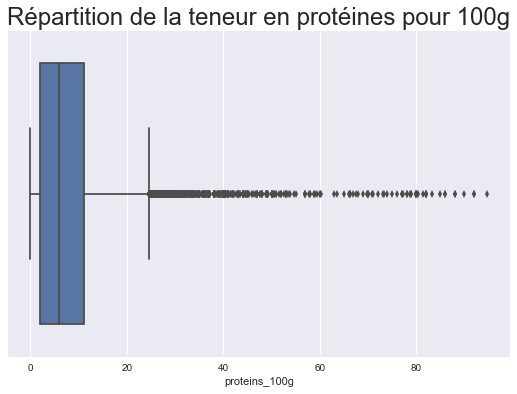

In [19]:
BoxPlot1D(Data['proteins_100g'], 'Répartition de la teneur en protéines pour 100g')

Zones de commentaires :   
La distribution de la teneur en protéines est bimodale, de modes 0 et 8. Encore une fois, on constate que 
la grande majorité des valeurs sont assez faibles, avec un 3ème quartile à 11.   
On identifie également de nombreux outliers, des produits riches en protéines. Ces produits correspondent
très souvent à des produits liés à la musculation : faibles en lipides et glucides et riches en protéines.

#### Etude de la variable 'kCal_100g'

La médiane de  Teneur en kiloCalories pour 100g est de  245.21400000000003
La moyenne de  Teneur en kiloCalories pour 100g est de  262.3505516149993


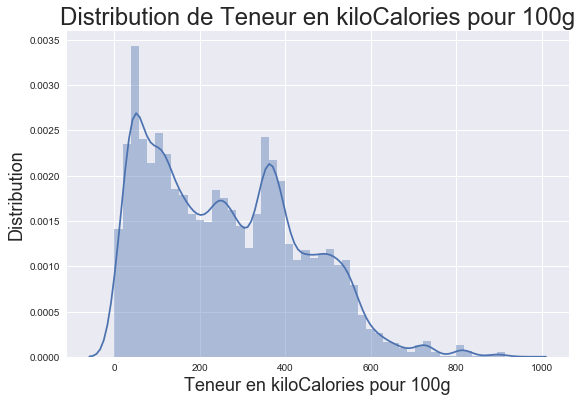

In [20]:
DistriPlot(Data['kCal_100g'],'Teneur en kiloCalories pour 100g')

count    82002.000000
mean       262.350552
std        177.161814
min          0.000000
25%        106.116000
50%        245.214000
75%        387.419000
max        950.981000
Name: kCal_100g, dtype: float64


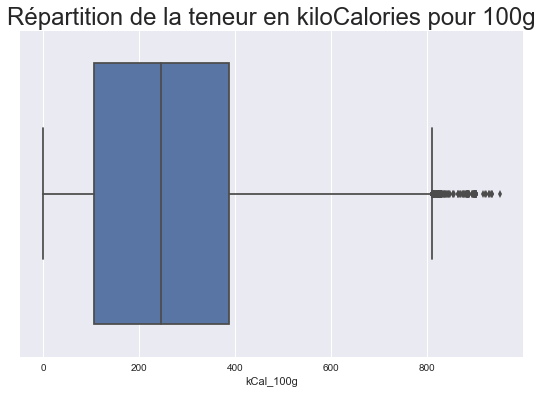

In [21]:
BoxPlot1D(Data['kCal_100g'], 'Répartition de la teneur en kiloCalories pour 100g')

Zones de commentaires :   
La distribution de la valeur énergétique est multimodale, avec un mode principal à 0.   
La moyenne et la médiane ont des valeurs assez proches.

# Etudes multivariées

## Etude sur les marques de distribution alimentaire

Identification des 20 plus grosses marques sur le marché des pays francophones

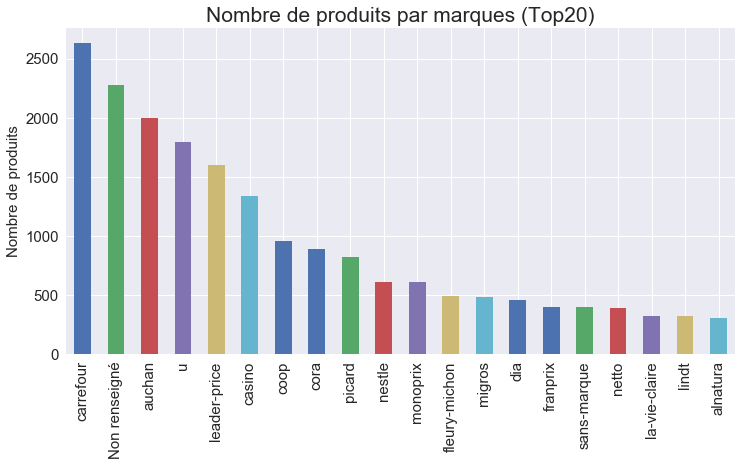

In [22]:
Brands20 = Data['brands_tags'].value_counts()[0:20]
Brands20.plot(kind='bar', figsize = (12,6),fontsize=15)
plt.title('Nombre de produits par marques (Top20)', fontsize = 21)
plt.ylabel('Nombre de produits', fontsize = 15)

plt.show()

In [23]:
# Récupération de la liste du Top20 marque 
Ix20 = Data['brands_tags'].value_counts()[0:20].index
Ix20.tolist()
print(Ix20)
# Création du dataframe filtré sur ces marques
df2 = Data[Data['brands_tags'].isin(Ix20)]

Index(['carrefour', 'Non renseigné', 'auchan', 'u', 'leader-price', 'casino',
       'coop', 'cora', 'picard', 'nestle', 'monoprix', 'fleury-michon',
       'migros', 'dia', 'franprix', 'sans-marque', 'netto', 'la-vie-claire',
       'lindt', 'alnatura'],
      dtype='object')


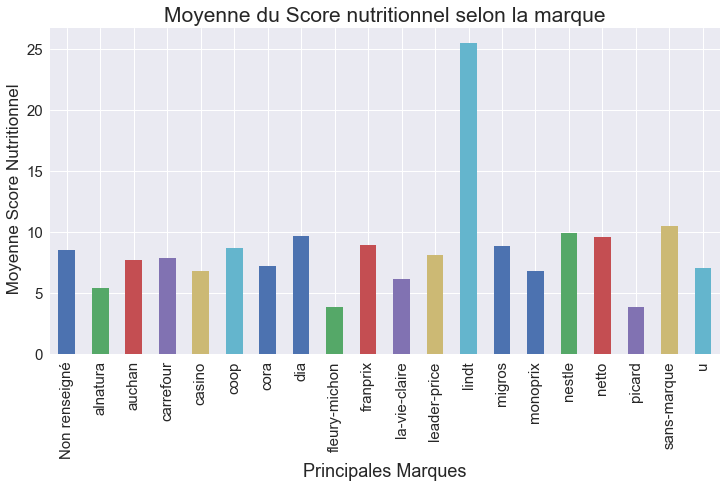

In [24]:
# Comparaison des marques en fonction de leur score moyen, de leur répartition du score
df2.groupby(['brands_tags'])['Score_Moyen'].mean().plot(kind='bar', figsize=(12,6),fontsize =15)
plt.title('Moyenne du Score nutritionnel selon la marque',fontsize = 21)                                                        
plt.xlabel('Principales Marques', fontsize = 18)
plt.ylabel(' Moyenne Score Nutritionnel',fontsize = 17)
# plt.legend(loc=0,fontsize=15)
plt.show()

Commentaires    
On voit que les marques "fleury-michon" (produits associés à la viande) et "picard"(produits et plats surgélés)
distribuent des produits ayant de meilleurs scores nutritionnels (en moyenne) que les autres marques.   
A l'inverse Lindt (spécialisé dans le chocolat) distribuent des produits moins "sains"


In [25]:
# Récupération de la liste du Top5 Marque 
Ix5 = Data['brands_tags'].value_counts()[0:6].index
Ix5.tolist()

# Création du dataframe filtré sur ces marques
df3 = Data[Data['brands_tags'].isin(Ix5)]
df3 = df3[df3['brands_tags'] != 'Non renseigné']

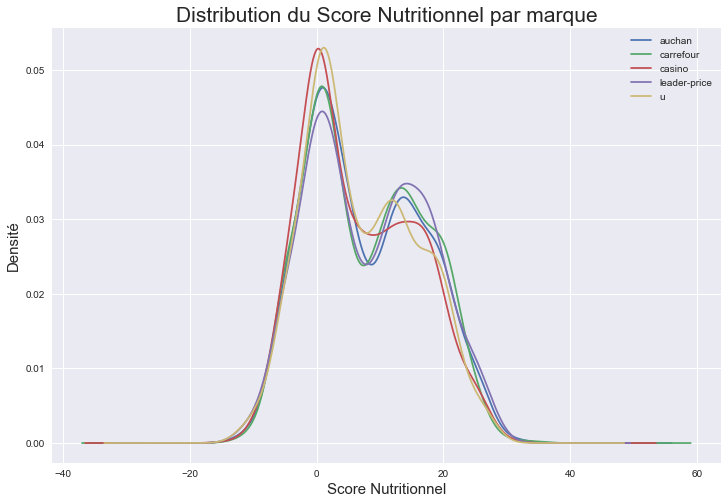

In [26]:
df3.groupby(['brands_tags'])['Score_Moyen'].plot(kind='kde',figsize = (12,8))
plt.title('Distribution du Score Nutritionnel par marque', fontsize = 21)
plt.xlabel('Score Nutritionnel', fontsize = 15)
plt.ylabel('Densité',fontsize = 15)
plt.legend()
plt.show()

Commentaires    
Les courbes de distribution du score nutritionnel se ressemblent beaucoup pour les 5 principaux distributeurs
alimentaires dans les pays francophones. On ne peut distinguer une marque plus "saine" que les autres

## Etude sur les catégories de produits 

In [27]:
print(len(Data['categories_fr'].unique()))
print(len(Data['main_category_fr'].unique()))

15081
1415


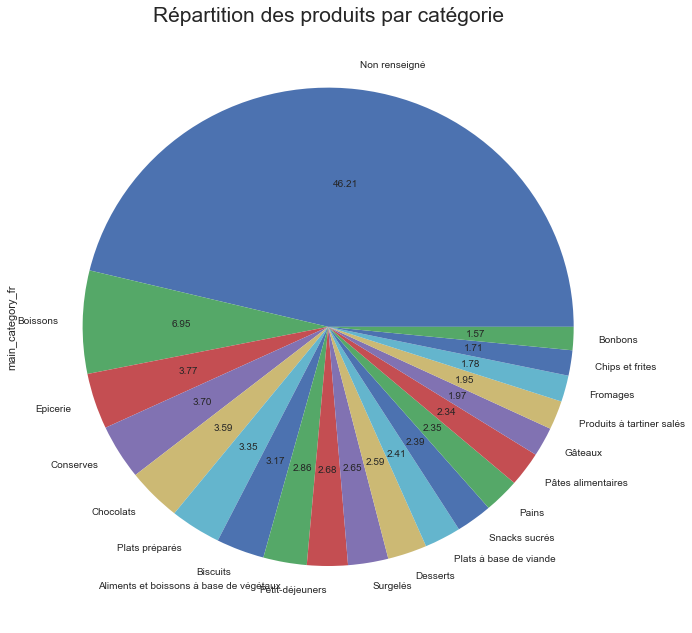

In [28]:
Cat15 = Data['main_category_fr'].value_counts()[0:20]
Cat15.plot(kind='pie', figsize=(11,11), autopct='%.2f', fontsize = 10)
plt.title('Répartition des produits par catégorie', fontsize = 21)
plt.show()


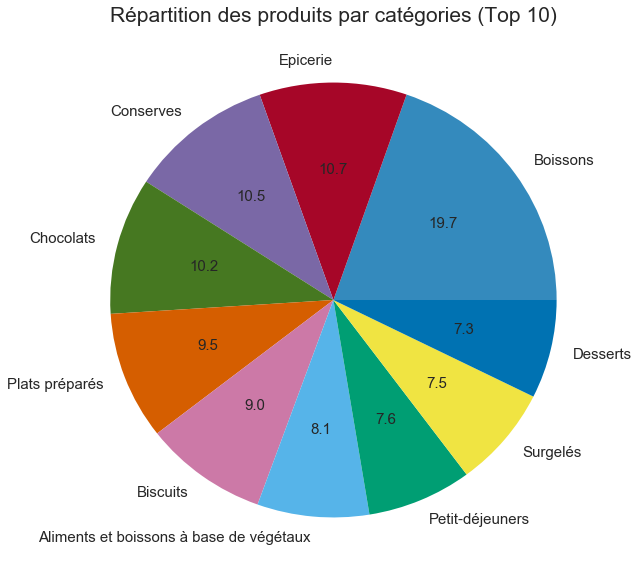

In [29]:
Cat10F = Data['main_category_fr'].value_counts()[1:11]

with plt.style.context(('bmh')):
    Cat10F.plot(kind='pie', figsize=(10,10), autopct='%.1f', fontsize =15)
    plt.title('Répartition des produits par catégories (Top 10)',fontsize=21)
    plt.ylabel('')
    plt.show()

In [30]:
# Récupération de la liste du Top6 catégorie
Ix6 = Data['main_category_fr'].value_counts()[1:6].index
Ix6.tolist()
#print(Ix20)
# Création du dataframe filtré sur ces marques
df4 = Data[Data['main_category_fr'].isin(Ix6)]

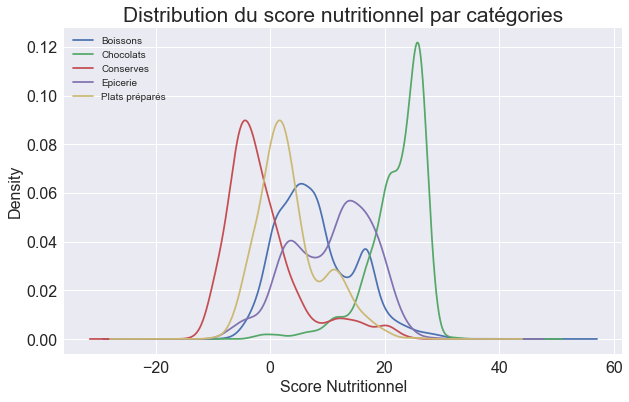

In [31]:
df4.groupby(['main_category_fr'])['Score_Moyen'].plot(kind ='kde', figsize = (10,6), fontsize = 16)
with plt.style.context(('seaborn')):
    plt.ylabel('Density', fontsize = 16)
    plt.xlabel('Score Nutritionnel', fontsize = 16)
    plt.legend(loc=2)
    plt.title('Distribution du score nutritionnel par catégories', fontsize = 21)
    plt.show()

Commentaires   
Les distributions du Score nutritionnel sont bien différenciées.    
Les conserves et les plats préparés sont des catégories de produits «sains»   
Confirmation que le chocolat n’est pas un produit sain nutritionnellement.   
Il semble exister deux sous catégories au sein de «Boissons» et «Epicerie»


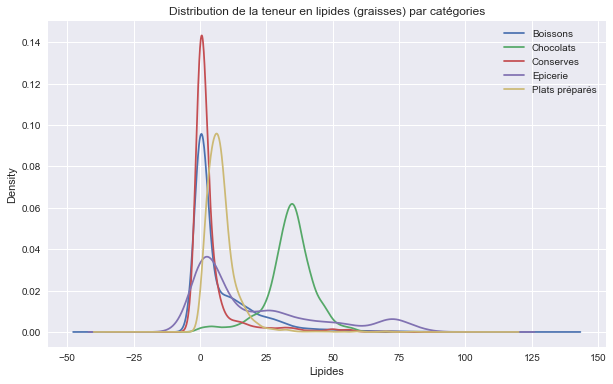

In [32]:
df4.groupby(['main_category_fr'])['fat_100g'].plot(kind ='kde', figsize = (10,6))
plt.ylabel('Density')
plt.xlabel('Lipides')
plt.legend()
plt.title('Distribution de la teneur en lipides (graisses) par catégories')
plt.show()

## Etude de l'influence des additifs et des produits issus de l'huile de palme (ou pouvant provenir de)

### Etude des additifs 

count    82002.000000
mean         1.792773
std          2.437841
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max         31.000000
Name: additives_n, dtype: float64


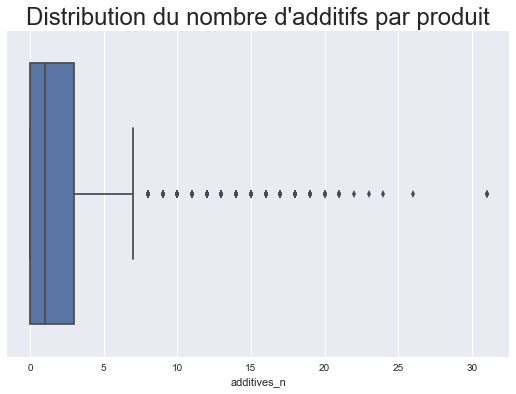

In [33]:
BoxPlot1D(Data['additives_n'], "Distribution du nombre d'additifs par produit")

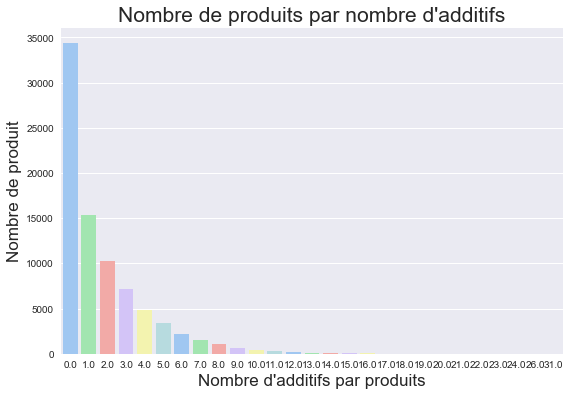

In [34]:
sns.countplot('additives_n', data = Data, palette = 'pastel')
plt.ylabel('Nombre de produit', fontsize = 17)
plt.xlabel("Nombre d'additifs par produits",  fontsize = 17)
plt.title("Nombre de produits par nombre d'additifs", fontsize = 21)
plt.show()

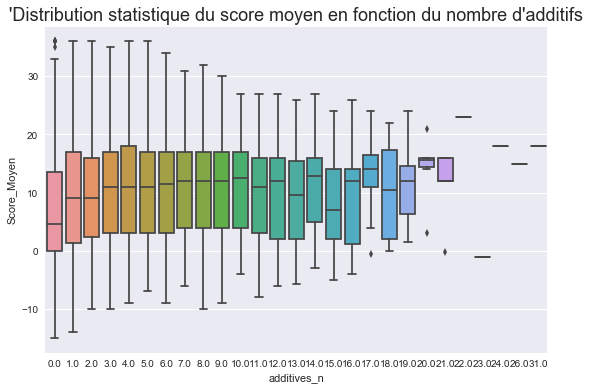

In [35]:
sns.boxplot(Data['additives_n'],Data['Score_Moyen'])
plt.title("'Distribution statistique du score moyen en fonction du nombre d'additifs", fontsize =18)
plt.show()

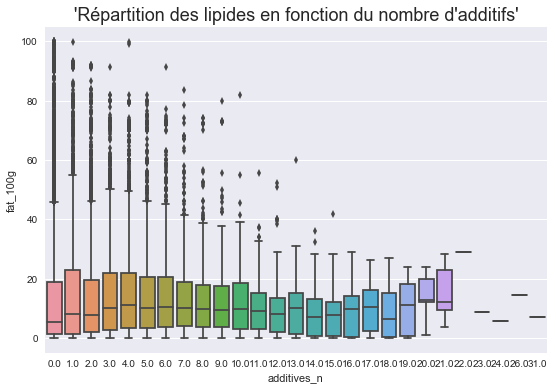

In [36]:
sns.boxplot(x=Data.additives_n , y = Data.fat_100g)
plt.title("'Répartition des lipides en fonction du nombre d'additifs'",fontsize =18)

plt.show()

In [37]:
# Commentaires

### Etude de l'effet des ingrédients issus de l'huile de palme (ou pouvant être issus)

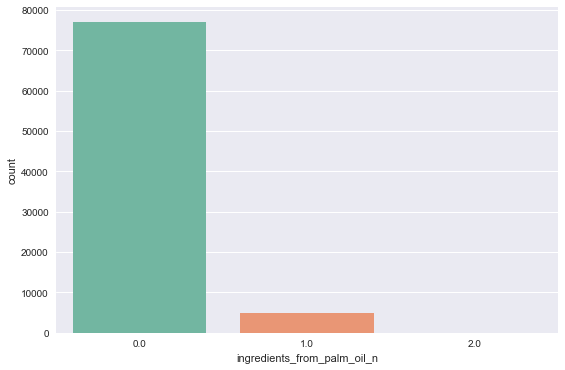

In [38]:
sns.countplot('ingredients_from_palm_oil_n', data = Data, palette = 'Set2')

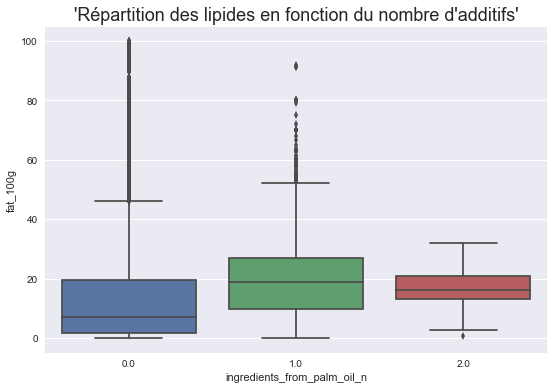

In [39]:
sns.boxplot(x=Data.ingredients_from_palm_oil_n , y = Data.fat_100g)
plt.title("'Répartition des lipides en fonction du nombre d'additifs'", fontsize = 18)
plt.show()

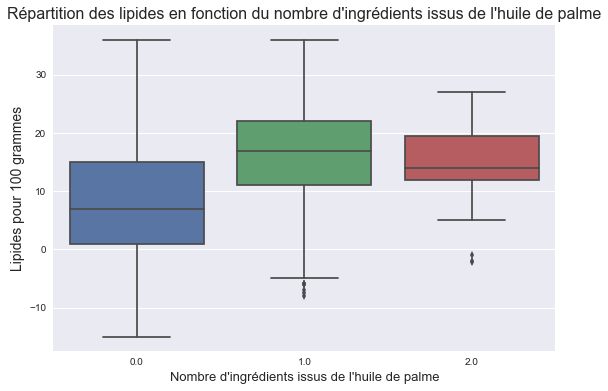

In [40]:
sns.boxplot(x=Data.ingredients_from_palm_oil_n , y = Data['Score_Moyen'])
plt.title("Répartition des lipides en fonction du nombre d'ingrédients issus de l'huile de palme", fontsize = 16)
plt.xlabel("Nombre d'ingrédients issus de l'huile de palme", fontsize = 13)
plt.ylabel("Lipides pour 100 grammes", fontsize = 14)
plt.show()

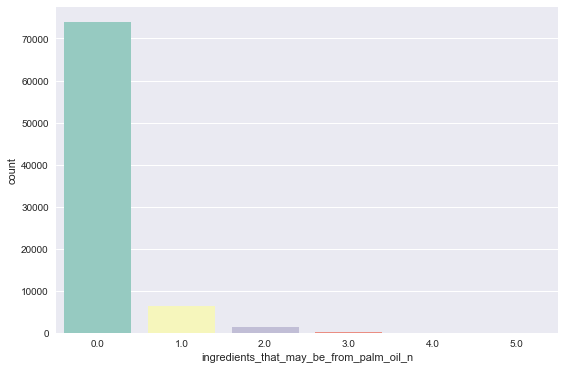

In [41]:
sns.countplot('ingredients_that_may_be_from_palm_oil_n', data = Data, palette = 'Set3')

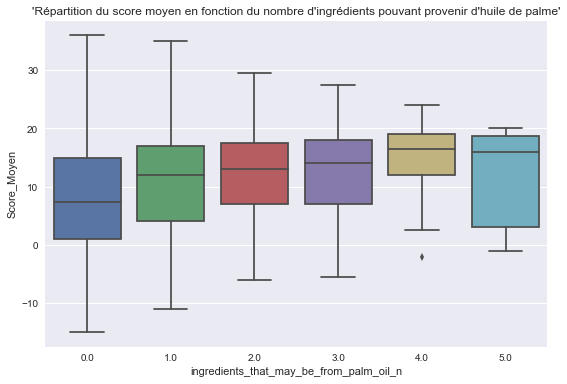

In [42]:
sns.boxplot(x=Data.ingredients_that_may_be_from_palm_oil_n , y = Data.Score_Moyen)
plt.title("'Répartition du score moyen en fonction du nombre d'ingrédients pouvant provenir d'huile de palme'")
plt.show()

In [43]:
# Commentaires

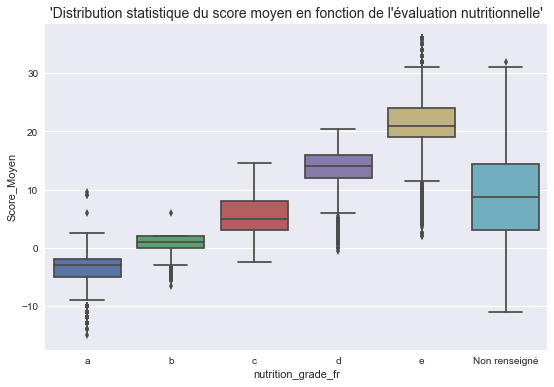

In [44]:
sns.boxplot(Data['nutrition_grade_fr'],Data['Score_Moyen'],order = ['a','b','c','d','e','Non renseigné'])
plt.title("'Distribution statistique du score moyen en fonction de l'évaluation nutritionnelle'", fontsize = 14)
plt.show()

# Etudes bivariées

#### Entre 'fat_100g' et 'saturated-fat_100g'

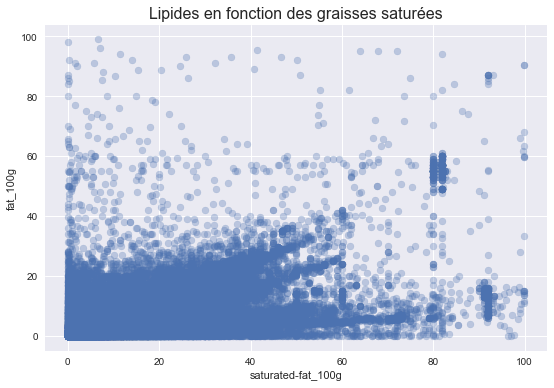

In [45]:
plt.scatter(y = Data['saturated-fat_100g'] , x = Data['fat_100g'],alpha=0.3)
plt.style.use('seaborn-deep')
plt.xlabel('saturated-fat_100g')
plt.ylabel('fat_100g')
plt.title('Lipides en fonction des graisses saturées', fontsize = 16)
plt.show()

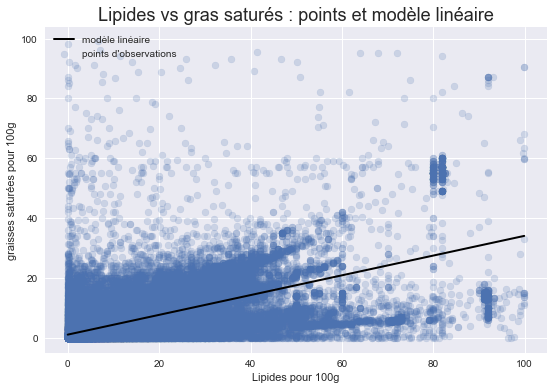

In [46]:
# Etude du couple lipides - graisses saturées
Fat = Data.fat_100g
Saturated_fat = Data['saturated-fat_100g']

Reg_mod = linear_model.LinearRegression()
Reg_mod.fit(Fat[:,np.newaxis],Saturated_fat)

ax = plt.axes()
plt.scatter(x = Data['fat_100g'] , y = Data['saturated-fat_100g'],alpha=0.2 , label ="points d'observations")

x_test = np.linspace(0, np.max(Fat), 100)
plt.plot(x_test, Reg_mod.predict(x_test[:,np.newaxis]), color='black', linewidth=2, label = 'modèle linéaire', alpha=1)

plt.title("Lipides vs gras saturés : points et modèle linéaire", fontsize = 18)
plt.legend(loc='upper left')

ax = ax.set(xlabel='Lipides pour 100g', ylabel='graisses saturées pour 100g')

plt.show()

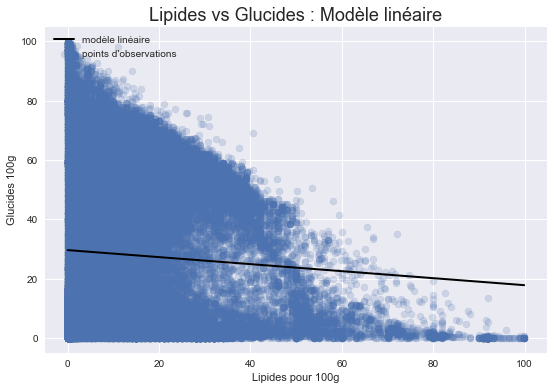

In [47]:
# Etude du couple lipides - glucides
Lipides = Data.fat_100g
Glucides = Data['carbohydrates_100g']

Reg_mod = linear_model.LinearRegression()
Reg_mod.fit(Lipides[:,np.newaxis],Glucides)

ax = plt.axes()
plt.scatter(x = Lipides , y = Glucides,alpha=0.2 , label ="points d'observations")

x_test = np.linspace(0, np.max(Lipides), 100)
plt.plot(x_test, Reg_mod.predict(x_test[:,np.newaxis]), color='black', linewidth=2, label = 'modèle linéaire', alpha=1)

plt.title("Lipides vs Glucides : Modèle linéaire", fontsize = 18)
plt.legend(loc='upper left')

ax = ax.set(xlabel='Lipides pour 100g', ylabel='Glucides 100g')

plt.show()

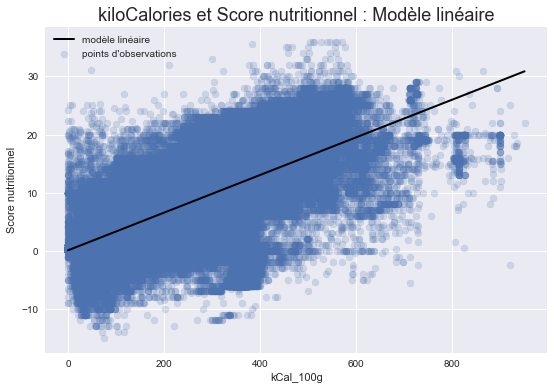

In [48]:
# Etude du couple kilocalories - score nutritionnel
kCal = Data.kCal_100g
Score_Moyen = Data['Score_Moyen']

Reg_mod = linear_model.LinearRegression()
Reg_mod.fit(kCal[:,np.newaxis],Score_Moyen)

ax = plt.axes()
plt.scatter(x = kCal , y = Score_Moyen,alpha=0.2 , label ="points d'observations")

x_test = np.linspace(0, np.max(kCal), 100)
plt.plot(x_test, Reg_mod.predict(x_test[:,np.newaxis]), color='black', linewidth=2, label = 'modèle linéaire', alpha=1)

plt.title("kiloCalories et Score nutritionnel : Modèle linéaire", fontsize = 18)
plt.legend(loc='upper left')

ax = ax.set(xlabel='kCal_100g', ylabel='Score nutritionnel')

plt.show()

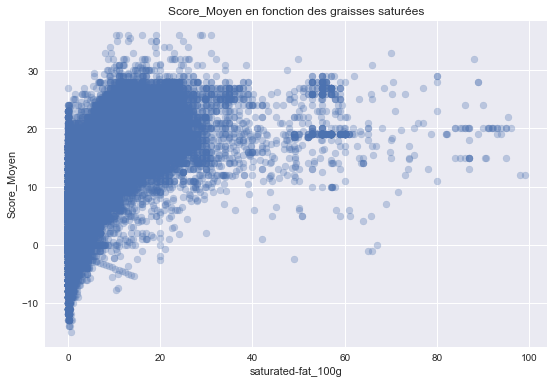

In [49]:
plt.scatter(x = Data['saturated-fat_100g'] , y = Data['Score_Moyen'],alpha=0.3)
plt.xlabel('saturated-fat_100g')
plt.ylabel('Score_Moyen')
plt.title('Score_Moyen en fonction des graisses saturées')
plt.show()

#### Etude du Score Moyen en fonction des kilosCalories

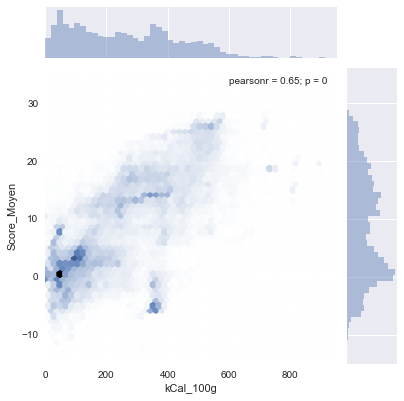

In [50]:
sns.jointplot(x = Data['kCal_100g'] , y = Data['Score_Moyen'], kind = 'hex')

#### Etude du lien entre Salt_100g et Sodium_100g

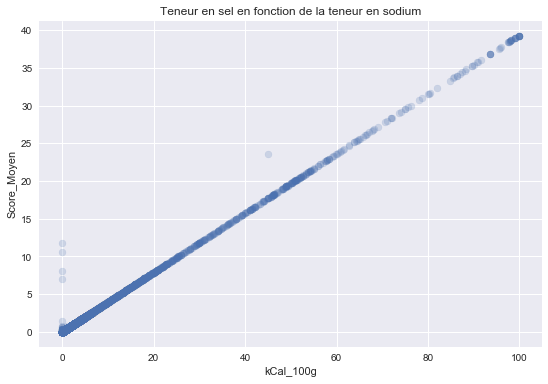

In [51]:
plt.scatter(x = Data['salt_100g'] , y = Data['sodium_100g'], alpha = 0.2)
plt.xlabel('kCal_100g')
plt.ylabel('Score_Moyen')
plt.title('Teneur en sel en fonction de la teneur en sodium')
plt.show()

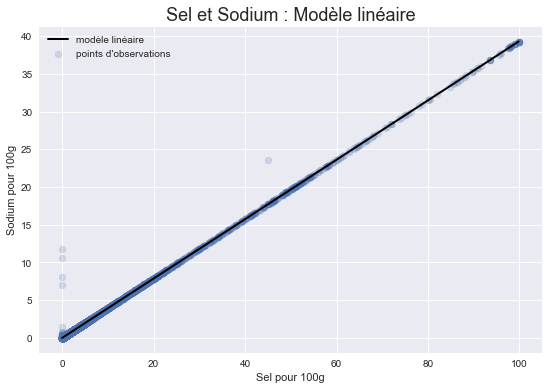

In [52]:
# Effectuer une reg lin et plot la reg lin sur le graphe 
Salt = Data.salt_100g
Sodium = Data['sodium_100g']

Reg_mod = linear_model.LinearRegression()
Reg_mod.fit(Salt[:,np.newaxis],Sodium)

ax = plt.axes()
plt.scatter(x = Salt , y = Sodium ,alpha=0.2 , label ="points d'observations")

x_test = np.linspace(0, np.max(Salt), 100)
plt.plot(x_test, Reg_mod.predict(x_test[:,np.newaxis]), color='black', linewidth=2, label = 'modèle linéaire', alpha=1)

plt.title("Sel et Sodium : Modèle linéaire", fontsize = 18)
plt.legend(loc='upper left')

ax = ax.set(xlabel='Sel pour 100g', ylabel='Sodium pour 100g')

plt.show()

# Etude de corrélations 

In [53]:
def corrPearson(X,Y):
    corrs = st.pearsonr(X,Y)
    print("La valeur du coefficient de corrélation de Pearson (r) est : ", corrs[0])
    print("r^2 vaut donc : ", corrs[0]*corrs[0])
    print("La p-value de la méthode est : ", corrs[1])
    return(corrs)

def corrSpearman(X,Y):
    corrs = st.spearmanr(X,Y)
    print("La valeur du coefficient de corrélation de Spearman (r) est : ", corrs[0])
    print("r^2 vaut donc : ", corrs[0]*corrs[0])
    print("La p-value de la méthode est : ", corrs[1])
    return(corrs)

def test_corr_Pearson(corrs,N):
    return()

In [54]:
Data_float.corr()

additives_n  \
additives_n                                 1.000000   
ingredients_from_palm_oil_n                 0.259810   
ingredients_that_may_be_from_palm_oil_n     0.443264   
fat_100g                                   -0.003825   
saturated-fat_100g                         -0.003814   
carbohydrates_100g                          0.110279   
sugars_100g                                 0.104323   
fiber_100g                                 -0.062778   
proteins_100g                              -0.065999   
salt_100g                                  -0.003976   
sodium_100g                                -0.004074   
SommeGPL                                    0.077510   
Score_Moyen                                 0.163927   
kCal_100g                                   0.044471   

                                         ingredients_from_palm_oil_n  \
additives_n                                                 0.259810   
ingredients_from_palm_oil_n                                 1.000000   
ingredients_that_may_be_from_palm_oil_n                     0.180366   
fat_100g                                                    0.121397   
saturated-fat_100g                                          0.125442   
carbohydrates_100g                                          0.220035   
sugars_100g                                                 0.164193   
fiber_100g                                                  0.021240   
proteins_100g                                              -0.039466   
salt_100g                                                   0.016641   
sodium_100g                                                 0.016851   
SommeGPL                                                    0.242887   
Score_Moyen                                                 0.223560   
kCal_100g                                                   0.210822   

                                         ingredients_that_may_be_from_palm_oil_n  \
additives_n                                                             0.443264   
ingredients_from_palm_oil_n                                             0.180366   
ingredients_that_may_be_from_palm_oil_n                                 1.000000   
fat_100g                                                                0.055240   
saturated-fat_100g                                                      0.045367   
carbohydrates_100g                                                      0.116786   
sugars_100g                                                             0.049605   
fiber_100g                                                             -0.022096   
proteins_100g                                                          -0.052837   
salt_100g                                                              -0.010939   
sodium_100g                                                            -0.010925   
SommeGPL                                                                0.116306   
Score_Moyen                                                             0.114131   
kCal_100g                                                               0.101663   

                                         fat_100g  saturated-fat_100g  \
additives_n                             -0.003825           -0.003814   
ingredients_from_palm_oil_n              0.121397            0.125442   
ingredients_that_may_be_from_palm_oil_n  0.055240            0.045367   
fat_100g                                 1.000000            0.616873   
saturated-fat_100g                       0.616873            1.000000   
carbohydrates_100g                      -0.068730           -0.017756   
sugars_100g                              0.019777            0.096835   
fiber_100g                               0.017201           -0.014318   
proteins_100g                            0.159000            0.154352   
salt_100g                                0.011347            0.005823   
sodium_100g                              0.011228      

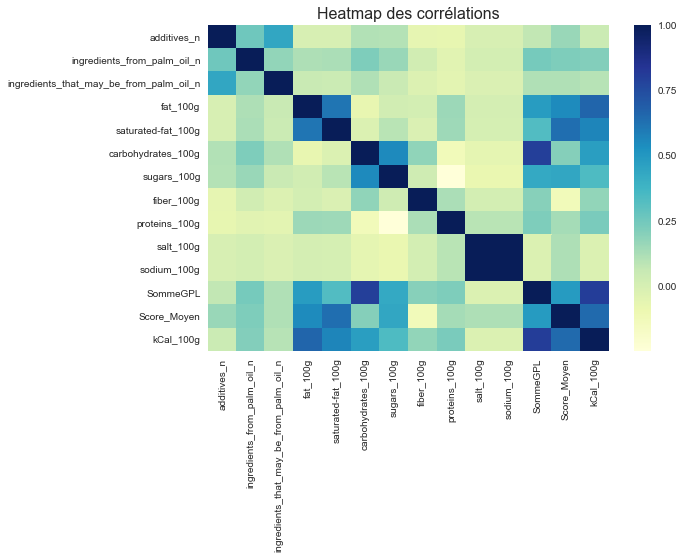

In [55]:
sns.heatmap(Data_float.corr(),cmap="YlGnBu")
plt.title('Heatmap des corrélations',fontsize = 16)
plt.show()

In [56]:
df1 = Data_float.iloc[:,[3,4,5,8,12,13]]
df1corr = df1.corr().round(decimals=3)
df1corr

fat_100g  saturated-fat_100g  carbohydrates_100g  \
fat_100g               1.000               0.617              -0.069   
saturated-fat_100g     0.617               1.000              -0.018   
carbohydrates_100g    -0.069              -0.018               1.000   
proteins_100g          0.159               0.154              -0.124   
Score_Moyen            0.547               0.636               0.208   
kCal_100g              0.665               0.569               0.477   

                    proteins_100g  Score_Moyen  kCal_100g  
fat_100g                    0.159        0.547      0.665  
saturated-fat_100g          0.154        0.636      0.569  
carbohydrates_100g         -0.124        0.208      0.477  
proteins_100g               1.000        0.138      0.231  
Score_Moyen                 0.138        1.000      0.650  
kCal_100g                   0.231        0.650      1.000

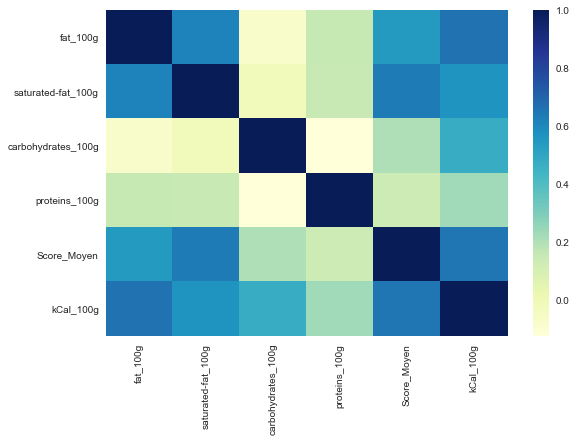

In [57]:
sns.heatmap(df1.corr(),cmap="YlGnBu")

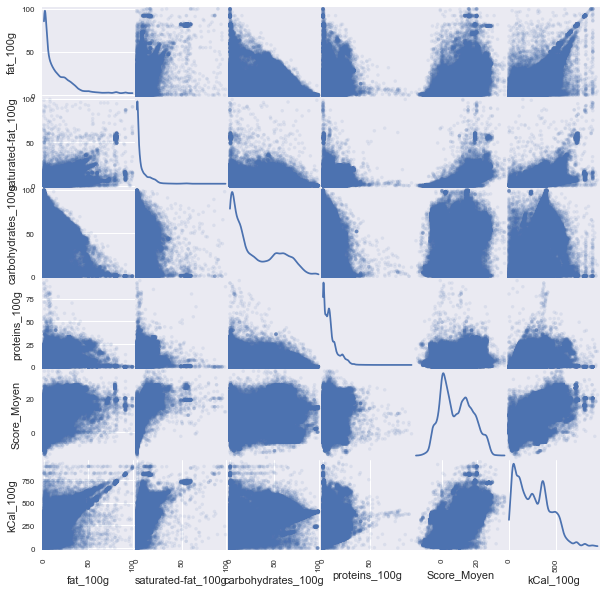

In [58]:
pd.plotting.scatter_matrix(df1,alpha=0.1, figsize=(10, 10), diagonal = 'kde')
#plt.title('Scatter Matrix des 6 variables retenues')
plt.show()

In [59]:
st.pearsonr(Data['salt_100g'],Data['sodium_100g'])

(0.9990299629117508, 0.0)

### Tests autour du Chi-2

In [60]:
Ix5 = Data['brands_tags'].value_counts()[0:6].index
Ix5.tolist()

# Création du dataframe filtré sur ces marques
df3 = Data[Data['brands_tags'].isin(Ix5)]

In [61]:
Ix6 = Data['main_category_fr'].value_counts()[1:6].index
Ix6.tolist()
#print(Ix20)
# Création du dataframe filtré sur ces marques
df4 = Data[Data['main_category_fr'].isin(Ix6)]

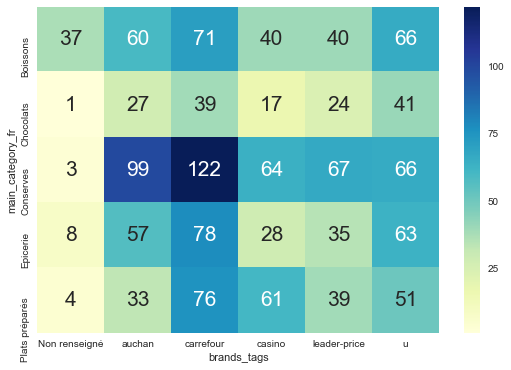

In [62]:
# Création du tableau de contingence entre les 5 marques principales et les 5 catégories principales
Obs = pd.crosstab(df3['main_category_fr'], df4['brands_tags'])
sns.heatmap(Obs, cmap="YlGnBu" , annot = True, fmt='d')


In [63]:
p_value = st.chi2_contingency(Obs)[1]
print(p_value)

1.4771903349020976e-15


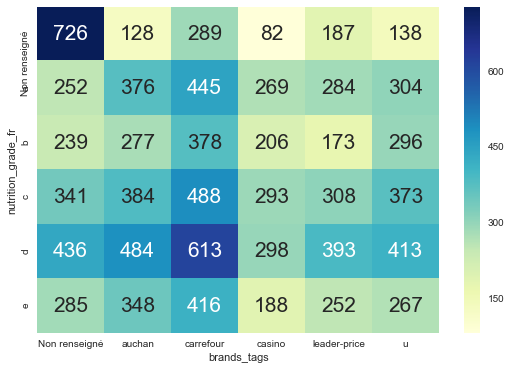

In [64]:
Obs2 = pd.crosstab(Data['nutrition_grade_fr'], df3['brands_tags'])
sns.heatmap(Obs2, cmap="YlGnBu" , annot = True, fmt='d')

In [65]:
p_value = st.chi2_contingency(Obs2)[1]
print(p_value)

3.503011939131508e-181


# Justification du choix de ne garder que Score_Moyen

In [66]:
Data = pd.read_csv('new_data_openfood.csv')
print(Data.columns)
DataScore = Data.iloc[:,[19,20,22]]
print(DataScore.columns)

Index(['Unnamed: 0', 'categories_fr', 'brands_tags', 'main_category_fr',
       'product_name', 'countries_fr', 'nutrition_grade_fr', 'additives_n',
       'ingredients_from_palm_oil_n',
       'ingredients_that_may_be_from_palm_oil_n', 'energy_100g', 'fat_100g',
       'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g',
       'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g',
       'nutrition-score-uk_100g', 'SommeGPL', 'Score_Moyen', 'kCal_100g'],
      dtype='object')
Index(['nutrition-score-fr_100g', 'nutrition-score-uk_100g', 'Score_Moyen'], dtype='object')


La moyenne du score nutritionnel des produits est  8.573


<function matplotlib.pyplot.show>

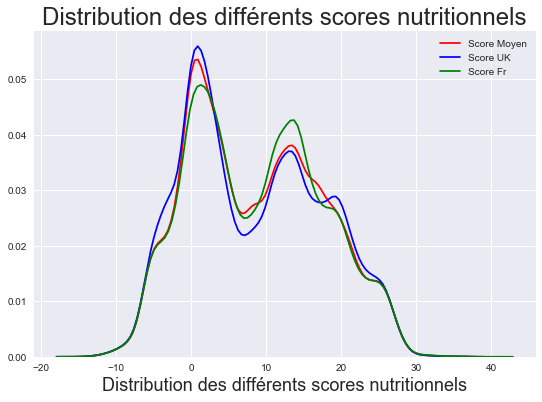

In [67]:
print("La moyenne du score nutritionnel des produits est ", np.around(Data.Score_Moyen.mean(), 3))
sns.distplot(Data.Score_Moyen, hist=False, color = 'r', label = 'Score Moyen')
sns.distplot(Data['nutrition-score-uk_100g'], hist=False, color = 'blue',label = "Score UK")
sns.distplot(Data['nutrition-score-fr_100g'], hist=False, color = 'green', label = 'Score Fr')
plt.xlabel('Distribution des différents scores nutritionnels', fontsize = 18)
plt.legend()
plt.title('Distribution des différents scores nutritionnels',fontsize =24)
plt.show

In [68]:
DataScore.corr()

nutrition-score-fr_100g  nutrition-score-uk_100g  \
nutrition-score-fr_100g                  1.00000                  0.96435   
nutrition-score-uk_100g                  0.96435                  1.00000   
Score_Moyen                              0.99074                  0.99135   

                         Score_Moyen  
nutrition-score-fr_100g      0.99074  
nutrition-score-uk_100g      0.99135  
Score_Moyen                  1.00000